<a href="https://colab.research.google.com/github/zackives/upenn-cis5450-hw/blob/main/Module_1_Data_Acquisition_Wrangling_Linking_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I of Big Data Analytics - Notebook 3

## Recall

As we start our journey into Big Data Analytics, the first thing we need to do is **get the data** in the form we need for analysis!  We'll start with an overview of how to acquire and *wrangle* data.

This notebook will be built incrementally to consider several tasks:

* Acquiring data from files and remote sources
* Information extraction over HTML content
* A basic "vocabulary" of operators over tables (the relational algebra)
* Basic manipulation using SQL in DuckDB

* "Data wrangling" or integration:
  * Cleaning and filtering data, using rules and based operations
  * Linking data across dataframes or relations
  * The need for approximate match and record linking
  * Different techniques

## Before you start this notebook

Make sure you did the exercises in [Notebook 1](https://colab.research.google.com/github/zackives/upenn-cis5450-hw/blob/main/Module_1_Data_Acquisition.ipynb)! and [Notebook 2](https://colab.research.google.com/github/zackives/upenn-cis5450-hw/blob/main/Module_1_Data_Acquisition_Wrangling_II.ipynb).

Note that as you execute some of the dependency cells below, you'll have to restart your notebook a couple of times.

## The Motivating Question
To illustrate the principles, we focus on the question of **how old company CEOs and founders** (in general, leaders) are.  The question was in part motivated by the following New York Times article:

* Founders of Successful Tech Companies Are Mostly Middle-Aged: https://www.nytimes.com/2019/08/29/business/tech-start-up-founders-nest.html?searchResultPosition=2

So let's test this hypothesis!

# 3.0: Validating and Cleaning Data

How do we know our data is good?  We can create rules that trigger when the data fails some particular set of **constraints**.

## Libraries


This will take a while to install and requires that you Restart your runtime after.

In [ ]:
!pip3 install setuptools==72.2.0

In [ ]:
!pip3 install git+https://github.com/anhaidgroup/py_stringsimjoin.git@rel_0_3_6

In [ ]:
!pip install https://www.cis.upenn.edu/~zives/linktransformer-0.1.17-py3-none-any.whl

In [ ]:
!pip install --upgrade torch torchvision linktransformer scikit-learn datasets==2.14.5

In [ ]:
!pip install editdistance
!pip install validators

In [ ]:
!pip3 install duckdb

In [ ]:
!pip3 install lxml

In [ ]:
# Approximate string matching, see
import py_stringsimjoin as ssj
import py_stringmatching as sm

import linktransformer as lt
import pandas as pd
import numpy as np

import urllib
from lxml import etree

import datetime
import duckdb

In [ ]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

In [ ]:
!pip3 install penngrader-client

For quiz credit you'll need to update your student ID here!

In [ ]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 99999999 # YOUR PENN-ID GOES HERE AS AN INTEGER##PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO

Quizzes will cumulatively count as HW9... Don't edit this...

In [ ]:
%set_env HW_ID=cis5450_25f_HW9

In [ ]:
import os
from penngrader.grader import *

grader = PennGrader('notebook-config.yaml', os.environ['HW_ID'], STUDENT_ID, STUDENT_ID)

In [ ]:
# Imports we'll use through the notebook, collected here for simplicity

# For parsing dates and being able to compare
import datetime

# For fetching remote data
import urllib
import urllib.request

# Pandas dataframes and operations
import pandas as pd

# Numpy matrix and array operations
import numpy as np

# Sqlite is a simplistic database
import duckdb

# Data visualization
import matplotlib



### Reload

We reset the kernel, so we may need to re-initialize our data...

For simplicity, we reload all of the following:
* `company_ceos_df` -- Wikipedia list of companies and their CEOs
* `exec_df` -- crawled executive names and birthdays
* `company_data_df` -- 7M entries about companies
* `company_info_df` -- CSV about companies and lines of business

In [ ]:
!wget -nc https://storage.googleapis.com/penn-cis5450/companies_sorted.csv

In [ ]:
def get_ceo_urls(company_ceos_df):
  crawl_list = []

  for executive in company_ceos_df['Executive']:
    crawl_list.append('https://en.wikipedia.org/wiki/' + executive.replace(' ', '_'))
  return crawl_list

def import_html(url: str):
  # Now let's read an HTML table!
  headers = {
      'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
  }

  return requests.get(url, headers=headers).text


In [ ]:
import requests
from io import StringIO

url = 'https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs'
company_ceos_df = pd.read_html(StringIO(import_html(url)))[1]

# Use urllib.urlopen to crawl all pages in crawl_list, and store the response of the page
# in list pages

pages = []
page_urls = []

crawl_list = get_ceo_urls(company_ceos_df)

crawl_list

for url in crawl_list:
    page = url.split("/")[-1] #extract the person name at the end of the url

    # An issue: some of the accent characters won't work.  We need to convert them
    # into an HTML URL.  We'll split the URL, then use "parse.quote" to change
    # the structure, then re-form the URL
    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      response = import_html(url_ascii)
      #Save page and url for later use.
      pages.append(response)
      page_urls.append(url)
    except requests.exceptions.RequestException as e:
      print(e)


# Use lxml.etree.HTML(...) on the HTML content of each page to get a DOM tree that
# can be processed via XPath to extract the bday information.  Store the CEO name,
# webpage, and the birthdate (born) in exec_df.

# We first check that the HTML content has a table of type `vcard`,
# and then extract the `bday` information.  If there is no birthdate, the datetime
# value is NaT (not a type).

from lxml import etree

rows = []
for i, page in enumerate(pages):
  url = page_urls[i]
  print (url)
  content = page
  tree = etree.HTML(content)  #create a DOM tree of the page
  bday = tree.xpath('//table[contains(@class,"vcard")]//span[@class="bday"]/text()')
  if len(bday) > 0:
      name = url[url.rfind('/')+1:] # The part of the URL after the last /
      rows.append({'name': name, 'page': url,
                  'born': datetime.datetime.strptime(bday[0], '%Y-%m-%d')})
  else:
          rows.append({'name': url[url.rfind('/')+1:], 'page': url
                                    , 'born': np.datetime64('NaT')})

exec_df = pd.DataFrame(rows)
exec_df['clean_name'] = exec_df['name'].apply(lambda x: x.replace('_', ' '))
company_data_df = pd.read_csv('companies_sorted.csv')
countries_df = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")

data = urllib.request.urlopen(\
       'https://gist.github.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv')

company_info_df = pd.read_csv(data)


In [ ]:
updated_exec_df = exec_df.rename({'name': 'old_name'})
updated_exec_df

In [ ]:
# Test with validation rules

replace_item = ''

failed = False
for name in exec_df['clean_name']:
  if not name.replace(' ', replace_item).\
          replace('.', replace_item).\
          replace('\'',replace_item).\
          replace('-',replace_item).isalpha():
    print ("Illegal name %s"%name)
    failed = True

if failed:
  print('Found illegal names!')

## 3.1. Data Cleaning: Fixing the Errors

One approach we could take is to realize that these are all strings in which accented characters are specially coded for use in (Wikipedia) URLs.  For instance, %C3 is a hex character code for an accented "u".  We can use a function called `unqote` to fix this...


In [ ]:
from urllib.parse import unquote

exec_df['clean_name'].apply(unquote)

## 3.2. More Generally: Data Validation Tools

Are there tools to help us validate data?  Of course!  We see an [example](https://validators.readthedocs.io/en/latest/) of one such tool, simply called `validators`, below.  There are many others in the data cleaning literature.

In [ ]:
import validators.url

# Are all of the URLs valid?
exec_df['page'].apply(validators.url)

## 3.3. Validation against a master list

We can also compare against "master" lists (in tables).  For example, company info about stock ticker symbols can be compared against the full list of symbols; states and countries can be compared against definitive lists.

Suppose we want to confirm that `company_info_df`, which includes companies' home countries, has valid country codes.  


In [ ]:
data = urllib.request.urlopen(\
       'https://gist.github.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv')

company_info_df = pd.read_csv(data)


In [ ]:
company_info_df[['name','country_code']]

Some of these are NaNs -- let's drop them...

From someone's Github content, here's a nice list of all countries and region codes.

In [ ]:
countries_df = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")

display(countries_df)

In [ ]:
validated = company_info_df[['name','country_code']].dropna().merge(countries_df, left_on=['country_code'], right_on=['alpha-3'],
                      how='left', indicator=True)

validated[validated['_merge'] != 'both'][['name_x','country_code']].drop_duplicates()

Hmm, so Romania is not officially `ROM`.  (In it should be `ROU`.)

## 3.4. Record Linking: Working around the Errors

OK, so we have seen validation rules for the company country codes. Once we diagnose a problem, we can fix it.

### Back to person names

Rather than figuring out how to clean our names, we'll instead look at doing approximate matching.

### Simple Record Linking

We'll start with single-attribute record linking.

The first method will be "q-grams" and Jaccard similarity.

## Q-Grams, and Computing Jaccard Similarity in a Join

Recall that a $q$-gram is simply a $q$-character subset of a string (where the string is padded on the left and right by $q-1$ additional characters, often dollar signs).  We can define a *tokenizer* to take strings and turn them into *sets of q-grams*.

In [ ]:
# We are going to match the strings approximately, via "n-grams" or "q-grams" (sequences of n or q characters)
# Here it's five-grams

tok = sm.QgramTokenizer(qval=5,return_set=True)

With the tokenizer as a subroutine, we want to define a *Jaccard similarity join*.  This conceptually compares *all pairs* of tuples $r,s$ from tables $R$ and $T$.  For each $r$ and $s$, it computes the sets of q-grams for the join attributes.

Then it computes the *Jaccard distance* between the sets:

$$|qgrams(r) \cap qgrams(s)| / |qgrams(r) \cup qgrams(s)|$$

note, above, that these are sets so duplicate q-grams will not be considered.

In [ ]:
# Elon Musk is the CEO of Tesla and SpaceX so let's drop duplicates

updated_exec_df.drop_duplicates(inplace=True)

In [ ]:
# Now let's do a similarity join

updated_company_ceos_df = company_ceos_df.copy()

# We'll reset the index, so there is a unique index field in the company_ceos_df dataframe
updated_company_ceos_df.reset_index(inplace=True)

output_pairs = ssj.jaccard_join(updated_company_ceos_df, updated_exec_df, 'index', 'page', 'Executive', 'clean_name', tok, 0.35,
                                l_out_attrs=['Executive'], r_out_attrs=['name'])

output_pairs[output_pairs['_sim_score'] < 1.0]

In [ ]:
# CEO birthdays

ceo_bdays_df = updated_company_ceos_df.merge(output_pairs,left_on=['Executive'],right_on=['l_Executive']).\
        merge(updated_exec_df.dropna(),left_on=['r_page'],right_on=['page'])

ceo_bdays_df

## 3.5 Alternative Strategies for Record Linking

OK, we have people, what about company categories?  These are in `company_data_df`.

### Duplicate removal

There are some duplicate company entries, which will make everything a bit messy.  Let's just take the *first* entry for each.

In [ ]:
company_data_df[company_data_df['name'] == 'wells fargo']

We'll group companies by name, and take the *first* item in each group.

In [ ]:
# Let's get rid of 'Unnamed:0' as a column name so we can use it as an ID
updated_company_data_df = company_data_df.rename(columns={company_data_df.columns[0]: 'co_id'}).\
    groupby('name').first().reset_index()


In [ ]:
updated_company_data_df[updated_company_data_df['name'] == 'wells fargo']

OK, let's go onwards. We'll try to join from company CEOs to company data...

### Join on Lowercase

Obviously, company names are lowercased in `company_data_df`. Le's match that in `company_ceos_df`.

In [ ]:
updated_company_ceos_df['company_lc'] = updated_company_ceos_df['Company'].apply(lambda x: x.lower())

duckdb.sql("""SELECT *
              FROM updated_company_ceos_df cc JOIN updated_company_data_df cd
              ON cc.company_lc = cd.name""")


110 companies sounds pretty good.  But is that all of them?

`SELECT ... WHERE NOT EXISTS()` allows us to introduce a *correlated subquery*, i.e., a query that relates its conditions to values in the main query.

In [ ]:
missed_df = duckdb.sql("""SELECT *
              FROM updated_company_ceos_df cc
              WHERE NOT EXISTS(
                SELECT  * FROM company_data_df cd
                WHERE cc.company_lc = cd.name)""")

len(missed_df)

Wow, 25 companies are missing!  We can see them here...

In [ ]:
missed_df.df()[['company_lc']].sort_values(by='company_lc')

## Record Linking via Edit Distance

Given that the above company names don't match, let's see if we can do better using *edit distance* or *Levenshtein distance*. Here the problem formulation is to find the *smallest number of edits* (insert, replace, or delete a character) necessary to turn string $r$ into string $s$.

This is formulated as:
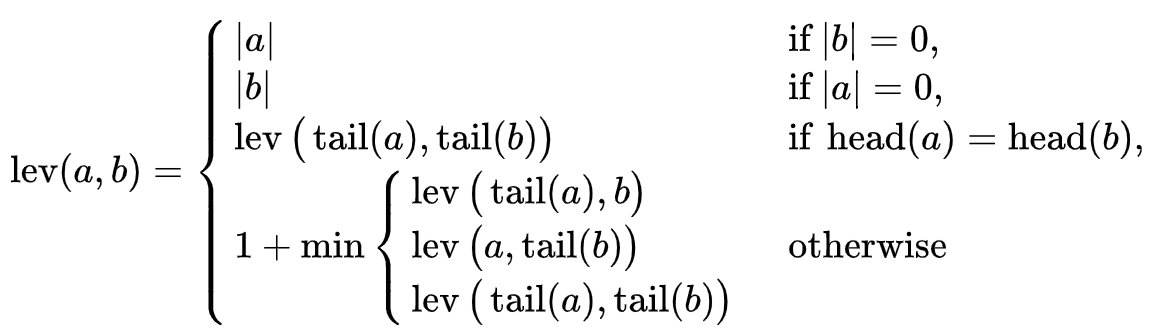

See the slides and [Wikipedia](https://en.wikipedia.org/wiki/Levenshtein_distance) for more details.

We'll look for matches with edit distance up to 2.  Note this will take quite some time, because it has to compare *all possible pairs of strings* and there are 25 x ~7 million.

In [ ]:
company_pairs = ssj.edit_distance_join(missed_df.df(), updated_company_data_df, 'index', 'co_id', 'company_lc', 'name', 2,
                                l_out_attrs=['company_lc'], r_out_attrs=['name'])

company_pairs

In [ ]:
company_pairs.sort_values(["_sim_score", "l_company_lc"], ascending=[True,True])

OK, so there are a LOT of partial matches.  Sometimes the closest match only requires one edit; other times, two.

#### Best Match

We want to start by finding the `argmin` values for `l_company_lc`
and `r_name`, i.e., the matching names with the most similar score.

As a starting point, let's figure out what the best score for each `l_company_lc` *is*...

In [ ]:
best_match_score_df = duckdb.sql("""
  SELECT l_company_lc, MIN(_sim_score) AS best_score
  FROM company_pairs
  GROUP BY l_company_lc
""").df()

best_match_score_df

Now we'll look for those matches. There are going to be a lot of ties (and we'll ultimately want to tie-break).

In [ ]:
best_matches_df = duckdb.sql("""
    SELECT l_index, company_pairs.l_company_lc, _sim_score, r_co_id, r_name
    FROM company_pairs
    JOIN best_match_score_df ON company_pairs._sim_score = best_match_score_df.best_score
         AND company_pairs.l_company_lc = best_match_score_df.l_company_lc
    ORDER BY company_Pairs.l_company_lc
  """).df()

best_matches_df

Let's tie-break by picking the `first` match for each `l_company_lc`. We'll use `GROUP BY` and `first` to do this...

In [ ]:
best_matches_df = duckdb.sql("""
    SELECT l_index, company_pairs.l_company_lc AS co, first(r_co_id) AS match_id, first(r_name) AS match
    FROM company_pairs
    JOIN best_match_score_df ON company_pairs._sim_score = best_match_score_df.best_score
         AND company_pairs.l_company_lc = best_match_score_df.l_company_lc
    GROUP BY l_index, company_pairs.l_company_lc
    ORDER BY company_pairs.l_company_lc
  """).df()

best_matches_df

### Concordance Table and Human Curation

When doing record linking, we ultimately need to create one "master list" of exact and inexact matches, so that a human expert can update mistakes.  For instance, looking above we might want to remove some entries.

In [ ]:
cleaned_matches_df = best_matches_df[(best_matches_df['co'] != 'bhp') & \
                (best_matches_df['co'] != 'boston consulting group') & \
                (best_matches_df['co'] != 'canonical') & \
                (best_matches_df['co'] != 'adobe systems') & \
                (best_matches_df['co'] != 'capital one financial') & \
                (best_matches_df['co'] != 'fox corporation') & \
                (best_matches_df['co'] != 'solera holdings') & \
                (best_matches_df['co'] != 'target corporation') & \
                (best_matches_df['co'] != 'warner brothers') & \
                (best_matches_df['co'] != 'warnermedia')]

To create the concordance table, we'll combine *exact match* cases (on lowercase) with the record linked data...

Notice that the concordance table is the UNION of two tables.

In [ ]:
concordance_table_df = duckdb.sql(
    """
      (SELECT index, Company as entry, match
      FROM updated_company_ceos_df JOIN cleaned_matches_df
        ON updated_company_ceos_df.company_lc = cleaned_matches_df.co
      UNION
      SELECT index, Company as entry, cd.name AS match
      from updated_company_ceos_df cc JOIN company_data_df cd
              ON cc.company_lc = cd.name
      ) ORDER BY entry
    """
).df()

concordance_table_df

### Done?

This is great, we have a few additional companies.

In the *exercises* you'll be asked to combine these with the other company data.

In [ ]:
# At last! Company info + CEO info, together!

total = updated_company_ceos_df.merge(output_pairs,left_on=['Executive'],right_on=['l_Executive']).\
        merge(updated_exec_df.dropna(),left_on=['r_page'],right_on=['page']).\
        merge(concordance_table_df, left_on='Company', right_on='entry').\
        merge(updated_company_data_df, left_on='match', right_on='name')\
        [['Company','name_y','Executive','r_name','born','_sim_score','industry','country','total employee estimate']]

total

In [ ]:
duckdb.sql("""
  CREATE TABLE company_ceo_age AS
  SELECT *
  FROM updated_company_ceos_df uc
    JOIN output_pairs op ON uc.Executive = op.l_Executive
    JOIN updated_exec_df e ON r_page = page
    JOIN concordance_table_df ct ON ct.entry = Company
    JOIN updated_company_data_df cd ON ct.match = cd.name
    WHERE born IS NOT NULL
""")

In [ ]:
duckdb.sql("SELECT * FROM company_ceo_age")

## 3.5 Deduplication

We have a series of associations between various companies and their industries.  Let's break this out into a table.

In [ ]:
industry_df = duckdb.sql("""
  SELECT industry, count(*) as frequency
  FROM updated_company_data_df
  WHERE industry IS NOT NULL
  GROUP BY industry
""").df()

industry_df

A simple form of deduplication is to find the *most general category* for each industry.  We'll in fact want to use this for identifying what companies are tech companies!

Here we want to use *semantic association* between terms.  Fortunately one class of tools that can match on semantics is *Transformers*.  A Transformer is a special machine learning model that maps from data (in this case, phrases) to _vectors_ in a compressed space.  This compressed space is formulated such that *similar vectors have similar semantic meaning*. We'll talk more about Transformers as we go.

In [ ]:
import linktransformer as lt

# Here are some basic high-level industry categories
categories_df = pd.DataFrame([{"category": "technology"},
                       {"category": "finance"},
                       {"category": "medicine"},
                       {"category": "services"},
                       {"category": "manufacturing"},
                       {"category": "entertainment"},
                       {"category": "religion"},
                       {"category": "government"},
                       {"category": "art"},
                       {"category": "retail"},
                       {"category": "food service"}])


# Let's do a concept-match
industry_categories_df = lt.merge(industry_df, categories_df,
                         merge_type='1:m',
                         left_on="industry",
                         right_on="category",
                         model="all-MiniLM-L6-v2")

In [ ]:
categories_df

### Deduplicated categories

Here are the frequencies of different categories...

In [ ]:
duckdb.sql("""
  SELECT category, SUM(frequency)
  FROM industry_categories_df
  WHERE score > 0.3
  GROUP BY category
""")

Great. Now let's deploy this information to our integration problem. We'll want to know what industries are tech industries, so we can *replace all industries with their broader category*.

If we just join with this list of industries, we'll get the set of tech companies.

In [ ]:
tech_categories_df = duckdb.sql("""
  SELECT industry, frequency, score
  FROM industry_categories_df
  WHERE category='technology'
   AND score > 0.3
  ORDER BY score DESC
""").df()

tech_categories_df

In [ ]:
tech_companies_df = total.merge(tech_categories_df, left_on='industry', right_on='industry')

## Section 3 Exercises

Is there a correlation between the kind of company and the age of the CEO?

Does the company's line of business matter?

In [ ]:
# TODO: use import_html to pull from https://en.wikipedia.org/wiki/List_of_women_CEOs_of_Fortune_500_companies,
# get the initial table, and convert to a DataFrame called women_ceos_df
women_ceos_df = # TODO
women_ceos_df


A few notes here!

1. Our previous company/CEOs table started with what Wikipedia folks thought were "interesting companies" -- mostly the famous ones.  That means *lots* of entries are missing (and the Wikipedia page even says so)!
2. This table starts with notable CEOs who are women, and the Wikipedia audience came up with a different list by starting there. There are quite a few folks missing from the first table! (Though a few folks, such as Mary Barra, do show up in both.)
3. Note that there are *LOTS* of other CEOs and companies still missing, even if we combine these two.  But combining these two will give us a lot more.
4. The Wikipedia authors came up with a different set of fields to capture, and a different schema.  We'll have to regularize.

In [ ]:
# TODO: copy entries from women_ceos_df but match the schema of company_ceos_df.
# You will have to fill in some missing info with plausible / reasonable values
company_ceos_2_df = pd.DataFrame(columns=['Company', 'Executive', 'Since', 'Title', 'Updated', 'Notes'])
company_ceos_2_df['Company'] =
company_ceos_2_df['Executive'] =
company_ceos_2_df['Since'] =
company_ceos_2_df['Title'] =
company_ceos_2_df['Updated'] =
company_ceos_2_df['Notes'] =
company_ceos_2_df

Let's re-run our fetch-personal-pages code from before.  We could have put this into a function, but we'll just reuse.

In [ ]:
pages = []
page_urls = []

for executive in company_ceos_2_df['Executive']:
  url = 'https://en.wikipedia.org/wiki/' + executive.replace(' ', '_')

  page = url.split("/")[-1] #extract the person name at the end of the url

  # An issue: some of the accent characters won't work.  We need to convert them
  # into an HTML URL.  We'll split the URL, then use "parse.quote" to change
  # the structure, then re-form the URL
  url_list = list(urllib.parse.urlsplit(url))
  url_list[2] = urllib.parse.quote(url_list[2])
  url_ascii = urllib.parse.urlunsplit(url_list)
  try:
    response = import_html((url_ascii))
    pages.append(response)
    page_urls.append(url_ascii)
  except requests.exceptions.RequestException as e:
    print(e.reason)

rows = []
for i, page in enumerate(pages):
  url = page_urls[i]

  content = page
  tree = etree.HTML(content)  #create a DOM tree of the page
  bday = tree.xpath('//table[contains(@class,"vcard")]//span[@class="bday"]/text()')
  if len(bday) > 0:
      name = url[url.rfind('/')+1:] # The part of the URL after the last /
      rows.append({'name': name, 'page': url,
                  'born': datetime.datetime.strptime(bday[0], '%Y-%m-%d')})
  else:
          rows.append({'name': url[url.rfind('/')+1:], 'page': url
                                    , 'born': np.datetime64('NaT')})

exec_2_df = pd.DataFrame(rows)
exec_2_df['clean_name'] = exec_2_df['name'].apply(lambda x: x.replace('_', ' '))

exec_2_df

Let's try Jaccard join on companies!

In [ ]:
updated_company_ceos_2_df = company_ceos_2_df.reset_index()
updated_company_ceos_2_df['company_lc'] = company_ceos_2_df['Company'].apply(lambda x: x.lower())
updated_company_ceos_2_df

output_pairs_2 = ssj.jaccard_join(updated_company_ceos_2_df, exec_2_df, 'index', 'page', 'Executive', 'clean_name', tok, 0.35,
                                l_out_attrs=['Executive'], r_out_attrs=['name'])


In [ ]:
missed_2_df = duckdb.sql("""SELECT *
              FROM updated_company_ceos_2_df cc
              WHERE NOT EXISTS(
                SELECT  * FROM company_data_df cd
                WHERE cc.company_lc = cd.name)""").df()

missed_2_df

In [ ]:
company_pairs_2 = ssj.edit_distance_join(missed_2_df, updated_company_data_df, 'index', 'co_id', 'company_lc', 'name', 2,
                                l_out_attrs=['company_lc'], r_out_attrs=['name'])

company_pairs_2

Referring back to the code for company_ceos, write a SELECT..FROM..GROUP BY query that takes the MIN distance (misleadingly called _sim_score when it's really distance_score) and returns that in a Dataframe called best_match_score_2_df.

In [ ]:
# TODO
best_match_score_2_df = duckdb.sql("""
  SELECT
  FROM
  GROUP BY
""").df()

best_match_score_2_df

Now we'll use that score to connect each entry with its best-match.

In [ ]:
best_matches_2_df = duckdb.sql("""
    SELECT l_index, cp.l_company_lc AS co, first(r_co_id) AS match_id, first(r_name) AS match
    FROM company_pairs_2 cp
    JOIN best_match_score_2_df bm ON cp._sim_score = bm.best_score
         AND cp.l_company_lc = bm.l_company_lc
    GROUP BY l_index, cp.l_company_lc
    ORDER BY cp.l_company_lc
  """).df()

best_matches_2_df

... Which leads to our Concordance Table!

In [ ]:
concordance_table_2_df = duckdb.sql(
    """
      (SELECT index, Company as entry, match
      FROM updated_company_ceos_2_df JOIN best_matches_2_df
        ON updated_company_ceos_2_df.company_lc = best_matches_2_df.co
      UNION
      SELECT index, Company as entry, cd.name AS match
      from updated_company_ceos_2_df cc JOIN company_data_df cd
              ON cc.company_lc = cd.name
      ) ORDER BY entry
    """
).df()

concordance_table_2_df

Now, try CREATE VIEW or CREATE TABLE to construct a DuckDB table called company_ceo_2_age, which joins updated_company_ceos_2_df with output_pairs_2 with exec_2_df with concordance_table_2_df with updated_company_data_df.  Drop anything without a birthday.

In [ ]:
# TODO
duckdb.sql("""
  CREATE VIEW company_ceo_2_age AS
  SELECT *
  FROM
""")

In [ ]:
submit_df = duckdb.sql('SELECT * FROM company_ceo_2_age').df()
submit_df

In [ ]:
grader.grade('women_ceo_age', submit_df)

## A Unified View ... and Provenance

We can create a single view of all company CEO info. Here, we might want to recall *where* we got different data from. We can do this by **tagging** tuples with information.


In [ ]:
duckdb.sql("""
  CREATE VIEW company_ceo_age_all AS
  SELECT '1' AS provenance, Company, Executive, Since, Title, born, country, domain, industry, \"total employee estimate\"
  FROM company_ceo_age
  UNION ALL
  SELECT '2' AS provenance, Company, Executive, Since, Title, born, country, domain, industry, \"total employee estimate\"
  FROM company_ceo_2_age
""")

Take a look at General Motors Corp in the results below.  You'll see two named CEOs (who should easily be deduplicable into one!).

In [ ]:
duckdb.sql("SELECT * FROM company_ceo_age_all WHERE Company='General Motors' ORDER BY Company").df()

# 4.0 Simple Analysis of Linked Data: Grouping and Analytics

The `groupby` command allows us to coalesce data by groups.  In Pandas a Group is a special object with a set of rows.  We can see this with the `get_group` command.

In [ ]:
tech_companies_df[['born','Company','Executive']].drop_duplicates().sort_values('born')

In [ ]:
tech_companies_df[['born','Company','Executive']].drop_duplicates().groupby(by='born').get_group(datetime.datetime.strptime('1972-06-10', '%Y-%m-%d'))[['Company','Executive','born']]

We can apply computations, such as `count`, to the items in the group.  Values that are empty (NaN) do not count (no pun intended).

In [ ]:
tech_companies_df[['born','Company','Executive']].drop_duplicates().groupby(by='born').count()

In [ ]:
# We can do this in SQL too...

# By default, SQL will include the Nan value (called NULL in SQL).  If we want to exclude it,
# we need to include WHERE ... IS NOT NULL.

duckdb.sql("""SELECT born, count(Company)
            FROM tech_companies_df
            WHERE born IS NOT NULL
            GROUP BY born""")

In [ ]:
total2 = tech_companies_df.dropna().copy()
total2['born'] = total2['born'].astype('datetime64[ns]')

In [ ]:
# Let's look at when the CEOs were born

birthdays = total2.groupby(by='born').count()[['Executive']]
birthdays.index = pd.to_datetime(birthdays.index, unit='s')

birthdays

We can actually use `resample` over dates, with a parameter, to group eg by decade (10 years, where A is the code for year):

In [ ]:
birthdays.resample('10A').count().plot(kind='bar')

In [ ]:
# Let's get ready to plot

%matplotlib inline

Maybe that's a little weird.  Can we do something more along the lines of what we expect, i.e., "1920s, 1930s, ..."?

In [ ]:
# Get rid of the nulls!
bdays = tech_companies_df[['born']].dropna()

bdays = bdays.applymap(lambda bday: str(int(bday.year / 10) * 10) + 's')

bdays.reset_index().groupby('born').count().plot(kind='bar')